In [1]:
main_dir = 'project_folder/'
func_dir = main_dir + 'utils/'

import sys
sys.path.insert(0,func_dir)


## Functions

### analysis functions

In [12]:
all_frames_reduced = {'SNR': 5, 'SNR_spont': 5, 'RS': 20, 
                      'RS_open':20, 'RS_closed': 20, 
                      'RF_thin':25, 'RF_large':25}
all_ini_stim_offs = {'SNR': 400, 'SNR_spont': 200, 'RS': None,
                      'RS_open':None, 'RS_closed': None, 
                      'RF_thin':1000, 'RF_large':1000, 'RF_thin_spont':200,'RF_large_spont':200}

condition_types =['SNR', 'SNR_spont', 'RS', 'RS_open', 'RS_closed', 'RF_thin', 'RF_large','RF_thin_spont','RF_large_spont']


In [16]:
import numpy as np
def get_subsamples(resp_array1, resp_array2, date, frame_lengths, seed=None):
    """gets frames subsamples from the different stimulus type recordings

    Args:
        resp_array1 (_type_): recording from area 1
        resp_array2 (_type_): recording from area 2
        date (_type_): date belonging to recording activity
        frame_lengths (_type_): dictionary containing the number of frames to subsample
        seed (_type_, optional): Defaults to None.

    Returns:
        resp_array1_subsampled, resp_array2_subsamped
    """
    if seed is not None:
        np.random.seed(seed)
    start_idx = np.random.randint(0,len(resp_array1)-frame_lengths[date])
    stop_idx = start_idx + frame_lengths[date]
    return resp_array1[start_idx:stop_idx], resp_array2[start_idx:stop_idx]
    

In [14]:
from ridge_regression_functions import get_best_alpha_evars
def process_evar_subsample_seeds(input_resp, pred_resp, date, min_lengths, seed, alphas, condition_type, n_splits=10, control_shuffle=False):
    """gets the inter-area prediction by subsampling frame size to make sure all stimulus types have a controlled training size

    Args:
        input_resp (_type_): area1 activity shaped (n_frames, n_neurons_or_sites)
        pred_resp (_type_): area2 activity shaped (n_frames, n_neurons_or_sites)
        date (_type_): date of recording
        min_lengths (_type_): _description_
        seed (_type_): _description_
        alphas (_type_): _description_
        condition_type (_type_): _description_
        n_splits (int, optional): _description_. Defaults to 10.
        control_shuffle (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: the prediction performances from both area1 and area2
    """
    pred_resp_sub, input_resp_sub= get_subsamples(pred_resp, input_resp, date, min_lengths, seed=seed)
        
    _, pred_evars = get_best_alpha_evars(input_resp_sub, pred_resp_sub, n_splits=n_splits, 
                                                    frames_reduced = all_frames_reduced[condition_type],
                                                    alphas=alphas, control_shuffle=control_shuffle)
    _, input_evars = get_best_alpha_evars(pred_resp_sub, input_resp_sub, n_splits=n_splits, 
                                                    frames_reduced = all_frames_reduced[condition_type],
                                                    alphas=alphas, control_shuffle=control_shuffle)
    return pred_evars, input_evars

### plotting functions

In [135]:
import pandas as pd
def extract_mouse_name(input_string):
    index_of_MP = input_string.find('MP')
    return input_string[index_of_MP:index_of_MP + 5] if index_of_MP != -1 and index_of_MP + 5 <= len(input_string) else None
def get_property_dataset_type(input_string):
    if 'spont' in input_string:
        return input_string.replace('_spont','')
    else:
        return input_string 
def make_mouse_df(mouse_stats_, dataset_types=['ori32','natimg32']):
    data = []
    for dataset_type in dataset_types:
        if 'spont' in dataset_type:
            act_type = 'gray screen'
        else:
            act_type = 'stimulus'
        for mouse, areas_data in mouse_stats_[dataset_type].items():
            mouse_name = extract_mouse_name(mouse)
            for area, values in areas_data.items():
                if area=='L23':
                    direction = 'L4→L2/3'
                    area_ = 'L2/3'
                else:
                    direction = 'L2/3→L4'
                    area_=area
                split_half_rs = mouse_stats[get_property_dataset_type(dataset_type)][mouse][area]['split_half_r']
                SNRs = mouse_stats[get_property_dataset_type(dataset_type)][mouse][area]['SNR_meanspont']
                for split_half_r, snr,max_corr_val, evar, null_evar in zip(split_half_rs, SNRs,values['max_corr_val'],values['evars'],values['evars_null']):
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Mouse': mouse,
                        'Mouse Name':mouse_name,
                        'Area': area_,
                        'Direction':direction,
                        'EV': evar,
                        'SNR': snr,
                        'Split-half r': split_half_r,
                        'max corr. val':max_corr_val,
                        'control_shuffle':False, 
                    })
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Mouse': mouse,
                        'Mouse Name':mouse_name,
                        'Area': area_,
                        'Direction':direction,
                        'EV': null_evar,
                        'SNR': snr,
                        'Split-half r': split_half_r,
                        'max corr. val':max_corr_val,
                        'control_shuffle':True, 
                    })
    # Create a DataFrame from the flattened data
    df_mouse_all = pd.DataFrame(data)
    return df_mouse_all

def get_property_dataset_type_monkey(input_string):
    if 'spont' in input_string:
        return input_string.replace('_spont','')
    elif 'RS' in input_string:
        return 'SNR'
    else:
        return input_string 

def make_monkey_df(monkey_stats_, dataset_types=['SNR', 'RF_thin', 'RF_large'], spont_comparisons=False):
    data = []
    for dataset_type in dataset_types:
        if 'spont' in dataset_type:
            act_type = 'gray screen'
        elif dataset_type=='RS':
            act_type = 'lights off'
        elif dataset_type =='RS_open':
            act_type = 'lights off\neyes open'
        elif dataset_type =='RS_closed':
            act_type = 'lights off\neyes closed'
        else:
            act_type = 'stimulus'
        for date, areas_data in monkey_stats_[dataset_type].items():
            for area, values in areas_data.items():
                if area=='V4':
                    direction = 'V1→V4'
                else:
                    direction = 'V4→V1'
                split_half_rs = monkey_stats_[get_property_dataset_type_monkey(dataset_type)][date][area]['split_half_r']
                SNRs = monkey_stats_[get_property_dataset_type_monkey(dataset_type)][date][area]['SNR_meanspont']
                if spont_comparisons is True:
                    if 'spont' not in dataset_type or 'RS' in dataset_type:
                        evars = values['spont_comparison_evars']
                        evars_null = values['spont_comparison_evars_null']
                        if len(evars.shape)>1:
                            evars = np.mean(evars, axis=0)
                            evars_null = np.mean(evars_null, axis=0)
                    else:
                        evars = values['evars']
                        evars_null = values['evars_null']
                else:
                    evars = values['evars']
                    evars_null = values['evars_null']
                
                for split_half_r, snr,max_corr_val, evar, null_evar in zip(split_half_rs, SNRs,values['max_corr_val'],evars,evars_null):
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Date':date,
                        'Area': area,
                        'Direction':direction,
                        'EV': evar,
                        'SNR': snr,
                        'max corr. val':max_corr_val,
                        'Split-half r': split_half_r,
                        'control_shuffle':False, 
                    })
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Date': date,
                        'Area': area,
                        'Direction':direction,
                        'EV': null_evar,
                        'SNR': snr,
                        'max corr. val':max_corr_val,
                        'Split-half r': split_half_r,
                        'control_shuffle':True, 
                    })
    # Create a DataFrame from the flattened data
    df_monkey_all = pd.DataFrame(data)
    return df_monkey_all

In [48]:
def perm_test(group1, group2):
    # Observed test statistic (e.g., difference in means)
    observed_statistic = np.nanmean(group1) - np.nanmean(group2)
    # Number of permutations to perform
    num_permutations = 10000
    # Create an array to store the permuted test statistics
    permuted_statistics = np.zeros(num_permutations)
    # Combine the data from both groups
    combined_data = np.concatenate((group1, group2))
    # Perform the permutation test
    for i in range(num_permutations):
        # Randomly shuffle the combined data
        np.random.shuffle(combined_data)
    
        # Split the shuffled data back into two groups
        permuted_group1 = combined_data[:len(group1)]
        permuted_group2 = combined_data[len(group1):]
        
        # Calculate the test statistic for this permutation
        permuted_statistic = np.nanmean(permuted_group1) - np.nanmean(permuted_group2)
        
        # Store the permuted test statistic
        permuted_statistics[i] = permuted_statistic

    # Calculate the p-value by comparing the observed statistic to the permuted distribution
    p_value = (np.abs(permuted_statistics) >= np.abs(observed_statistic)).mean()

    return p_value

def perm_test_paired(group1, group2):
    # Observed test statistic (e.g., difference in means)
    observed_statistic = np.nanmean(group2-group1)

    # Number of permutations to perform
    num_permutations = 10000

    # Create an array to store the permuted test statistics
    permuted_statistics = np.zeros(num_permutations)

    # Combine the differences
    pooled_differences = group2-group1
    
    # Perform the permutation test
    for i in range(num_permutations):
        # shuffle differences
        permuted_differences = pooled_differences * np.random.choice([-1, 1], size=len(pooled_differences))
        
        # Recalculate mean difference for the permuted dataset
        permuted_mean_difference = np.nanmean(permuted_differences)
    
        # Store the permuted mean difference
        permuted_statistics[i] = permuted_mean_difference

    # Calculate the p-value by comparing the observed statistic to the permuted distribution
    p_value = (np.abs(permuted_statistics) >= np.abs(observed_statistic)).mean()

    return p_value

# Function to perform hierarchical permutation test with animal bootstrapping
def hierarchical_permutation_test(data, mouse_or_date, dependent_variable, neuron_property,perm_type='ind', num_permutations=1000):
    observed_statistic = calculate_statistic(data, dependent_variable, neuron_property, perm_type)  # Replace with your actual calculation

    # Create an empty array to store permuted statistics
    permuted_statistics = np.zeros(num_permutations)

    # Iterate through each permutation
    for i in range(num_permutations):
        # Bootstrap animals (resample entire animals with replacement)
        bootstrap_animals_or_dates = np.random.choice(data[mouse_or_date].unique(), size=len(data[mouse_or_date].unique()), replace=True)
        data2 = data[data[mouse_or_date].isin(bootstrap_animals_or_dates)]
        if 'Mouse' in mouse_or_date:
        # bootstrapped_data = data[data[mouse_or_date].isin(bootstrap_animals_or_dates)]
            min_cells_per_mouse = min(data[data[mouse_or_date].isin(bootstrap_animals_or_dates)].groupby(['Mouse',dependent_variable])[neuron_property].count())
            bootstrapped_data = pd.concat([group_.sample(min_cells_per_mouse, replace=False) for _, group_ in data2.groupby(['Mouse',dependent_variable])])
        else:
            min_cells_per_date = min(data[data[mouse_or_date].isin(bootstrap_animals_or_dates)].groupby([mouse_or_date,dependent_variable])[neuron_property].count())
            bootstrapped_data = pd.concat([group_.sample(min_cells_per_date, replace=False) for _, group_ in data2.groupby([mouse_or_date,dependent_variable])])

        if perm_type =='ind':
            # Permute values within each bootstrapped animal
            for animal in bootstrapped_data[mouse_or_date].unique():
                animal_values = bootstrapped_data.loc[bootstrapped_data[mouse_or_date] == animal, neuron_property].values
                np.random.shuffle(animal_values)
                bootstrapped_data.loc[bootstrapped_data[mouse_or_date] == animal, neuron_property] = animal_values
            # Calculate the permuted statistic
            permuted_statistic = calculate_statistic(bootstrapped_data, dependent_variable, neuron_property, perm_type=perm_type)
        elif perm_type =='paired':
            permuted_statistic = calculate_statistic(bootstrapped_data, dependent_variable, neuron_property, perm_type=perm_type, paired_shuffle=True)
        # Store the permuted statistic
        permuted_statistics[i] = permuted_statistic
    # Calculate the p-value
    p_value = np.mean(np.abs(permuted_statistics) >= np.abs(observed_statistic))
    return p_value

# Example function for the statistic of interest
def calculate_statistic(data, group, neuron_property, perm_type='ind', paired_shuffle=False):
    groups = data[group].unique()
    if perm_type =='ind':
        mean_group_a = data[data[group] == groups[0]][neuron_property].mean()
        mean_group_b = data[data[group] == groups[1]][neuron_property].mean()
        return mean_group_a - mean_group_b
    elif perm_type =='paired':
        if data[data[group] == groups[0]][neuron_property].size != data[data[group] == groups[1]][neuron_property].size:
            print('sizes are not the same, you should not used a paired permutation test here')
            print(data[data[group] == groups[0]][neuron_property].size,data[data[group] == groups[1]][neuron_property].size)
        pooled_differences = data[data[group] == groups[0]][neuron_property].values-data[data[group] == groups[1]][neuron_property].values
        if paired_shuffle is True:
            permuted_differences = pooled_differences * np.random.choice([-1, 1], size=len(pooled_differences))
            # Recalculate mean difference for the permuted dataset
            return np.nanmean(permuted_differences)
        else:
            return np.nanmean(pooled_differences)


from scipy import stats
def get_t_test_stars(df_, dependent_variable, neuron_property, print_pval=False, 
                    perm_t=True, perm_type='ind', hierarchical=False, num_permutations=1000,mouse_or_date='Mouse Name'):
    
    variables = df_[dependent_variable].unique()
    group_1 =df_[df_[dependent_variable]==variables[0]][neuron_property].dropna().values
    group_2 =df_[df_[dependent_variable]==variables[1]][neuron_property].dropna().values
    
    if hierarchical is True:
        p_value = hierarchical_permutation_test(df_,mouse_or_date=mouse_or_date, 
                                        dependent_variable=dependent_variable, 
                                        neuron_property=neuron_property,
                                        perm_type=perm_type,num_permutations=num_permutations)
    
    elif perm_type=='paired':
        p_value = perm_test_paired(group_1, group_2)
    elif perm_t is True:
        p_value = perm_test(group_1, group_2)
    elif perm_type=='ind':
        _, p_value = stats.ttest_ind(group_1, group_2, equal_var=False)
    else:
        print('perm_type must be either ind or paired')
        return np.nan
    if p_value <1e-3:
        stars = '***'
    elif p_value <1e-2:
        stars = '**'
    elif p_value <0.05:
        stars='*'
    else:
        stars='n.s.'
    if print_pval is True:
        print(p_value)
    return stars

def add_stars_2_sets(df_, neuron_property, x, x_order, hue, ax, fontsize=7, height1=0.97, height2=0.97, perm_t=True, perm_type='ind', hierarchical=False, mouse_or_date='Mouse Name'):
    stars1 = get_t_test_stars(df_[df_[x]==x_order[0]], hue, neuron_property, perm_t=perm_t, perm_type=perm_type, hierarchical=hierarchical, mouse_or_date=mouse_or_date)
    stars2 = get_t_test_stars(df_[df_[x]==x_order[1]], hue, neuron_property, perm_t=perm_t, perm_type=perm_type,hierarchical=hierarchical, mouse_or_date=mouse_or_date)
    if stars1 == 'n.s.':
        height1 = height1 + 0.02
        fontsize1 = fontsize*0.9
        color1='#C0C0C0'
    else:
        fontsize1 = fontsize
        color1='black'
        
    if stars2 == 'n.s.':
        height2 = height2 + 0.02
        fontsize2 = fontsize*0.9
        color2='#C0C0C0'
    else:
        fontsize2 = fontsize
        color2='black'
    
    ax.text(0.25, height1, stars1, ha='center', va='center', fontsize=fontsize1, transform=ax.transAxes, color=color1)
    ax.text(0.75, height2, stars2, ha='center', va='center', fontsize=fontsize2, transform=ax.transAxes, color=color2)

In [193]:
import seaborn as sns
def fig5_violinplot(df, x, y, hue, ax, y_label, linewidth=0.9,
                    palette=['gray','lightgray'], fontsize=7,plot_control_ev=True, 
                    animal='mouse',show_legend=False,leg_loc=(1,0.3),**args):
    if animal == 'mouse':
        label_order=['L4→L2/3', 'L2/3→L4']
        hue_order=['stimulus', 'gray screen']
    elif animal =='monkey':
        label_order=['V1→V4', 'V4→V1']
        hue_order=['stimulus', 'gray screen','lights off',
                'lights off\neyes open','lights off\neyes closed']
        
    sns.violinplot(x=x, y=y, hue=hue, 
                data=df[df['control_shuffle']==False],ax=ax,order=label_order, hue_order=hue_order,
                inner='box',linewidth=linewidth,saturation=1,
                inner_kws={'box_width':2, 'whis_width':0.5,
                            'marker':'_', 'markersize':3,
                            'markeredgewidth':0.8,
                            },palette=palette,
                            **args
                            )
    sns.despine()
    ax.set_ylabel(y_label, fontsize=fontsize, labelpad=1)
    ax.set_xlabel(None)
    ax.legend_.remove()
    ax.spines[:].set_linewidth(0.3)
    if plot_control_ev is True:
        data = df[df['control_shuffle']==True][y]
        per_25 = np.percentile(data.dropna().values, 25)
        per_75 = np.percentile(data.dropna().values, 75)
        ax.axhspan(per_25, per_75, alpha=0.1, color='blue', label='shuffle\ncontrol IQR',
                linewidth=0,
                )
    if animal =='mouse':
        add_stars_2_sets(df[df['control_shuffle']==False], y, x, label_order, hue, ax, 
                    hierarchical=True, height1=0.7,height2=0.7, perm_type='paired')
    else:
        add_anova_stars_2_sets_5_conditions(df[df['control_shuffle']==False], y, x, label_order, hue, hue_order, ax, fontsize=5)
        if show_legend is True:
            hatch_size=3
            hatches = [None,None,None,'/','.',None]
            new_handles = []
            for handle, hatch in zip(ax.get_legend_handles_labels()[0], hatches):
                if hatch is not None:
                    handle.set_hatch(hatch*hatch_size)
                new_handles.append(handle)
            ax.legend(loc=leg_loc, handles = new_handles, fontsize=6)
    
    ax.tick_params(axis='both', labelsize=fontsize, width=0.5, length=3, pad=2)
    add_custom_colors(ax, animal=animal)
    
from matplotlib import collections
def add_custom_colors(ax, animal='mouse'):
    if animal=='mouse':
        custom_colors = ['#72BEB7','#B6E3DF','#EDAEAE', '#f6d6d6']
        violins  = [s for s in ax.get_children() if isinstance(s, collections.PolyCollection)]
        for violin, color in zip(violins, custom_colors):
            violin.set_facecolor(color)
    else:
        custom_colors = ['#72BEB7','#B6E3DF','#136a66','#136a66','#136a66',
                '#EDAEAE', '#f6d6d6','#a85959','#a85959','#a85959',]
        violins  = [s for s in ax.get_children() if isinstance(s, collections.PolyCollection)]
        for violin, color in zip(violins, custom_colors):
            violin.set_facecolor(color)
        inners = ax.get_lines()
        violin_indices= [2,3,4,7,8,9]
        inner_first_indices = [6,9,12,21,24,27]
        ofsett_val=0.06
        hatch_size=3
        for v,i in zip(violin_indices, inner_first_indices):
            violins[v].get_paths()[0].vertices[:,0] += ofsett_val
            inners[i].get_path().vertices[:,0]+= ofsett_val 
            inners[i+1].get_path().vertices[:,0]+= ofsett_val
            inners[i+2].get_path().vertices[:,0]+= ofsett_val
            if v==3 or v==8:
                violins[v].set_hatch('/'*hatch_size)
            if v==4 or v==9:
                violins[v].set_hatch('.'*hatch_size)
        
    

In [208]:
def plot_corrs_sns(corr_df, x, y, ax, xy=(0.05, 0.5), area='L2/3', color='black', 
                rcolor='black', alpha=0.5, s=8,fontsize=7, xlim=(-0.03,0.9), ylim=(-0.03,0.9), 
                tick_values = [0, 0.4, 0.8, ],**kwargs):
    df_area= corr_df[corr_df['Area']==area]
    if area =='L2/3' or area=='V4':
        color='lightseagreen'
        line_color='darkcyan'
    elif area=='L4' or area=='V1':
        color='lightcoral'
        line_color='#a85959'
    h = sns.scatterplot(x=x, y=y, color= color, 
                    data=df_area, alpha=alpha,s=s,ax=ax
            )
    sns.despine()
    
    h.tick_params(labelsize=16)
    pearson_corr = df_area[x].corr(df_area[y], method='pearson')
    h.annotate(f'r={pearson_corr:.2f}', xy=xy, fontsize=fontsize, color=rcolor)
    ax.set(xlim=xlim,
        ylim=ylim)
    tick_values = tick_values  # Define the tick values
    ax.set_xticks(tick_values)
    ax.set_yticks(tick_values)
    ax.tick_params(axis='both', labelsize=fontsize, width=0.5, length=2, pad=2)
    ax.set_xlabel('EV fraction\nstimulus',fontsize=fontsize, labelpad=1)
    ax.set_ylabel('EV fraction\ngray screen', fontsize=fontsize, labelpad=1)
    ax.spines[:].set_linewidth(0.3)
    max_val = df_area['EV'].max()
    ax.plot([0,max_val+0.05],[0,max_val + 0.05], color=line_color, linestyle='--', linewidth=1,)

In [118]:
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests
from itertools import combinations  # Import combinations from itertools with a different name

def get_one_way_anova_pstats(df,variable1,variable1_order, neuron_property,perm_t=False, perm_type='ind'):
    df_posthoc = df.dropna().copy()
    # Perform pairwise t-tests with Benjamini-Hochberg correction
    groups = variable1_order
    p_values = []
    p_val_names = []

    for group1, group2 in combinations(groups, 2):
        group1_data = df_posthoc[df_posthoc[f'{variable1}'] == group1][neuron_property]
        group2_data = df_posthoc[df_posthoc[f'{variable1}'] == group2][neuron_property]
        
        if perm_type == 'paired':
            p_value = perm_test_paired(group1_data, group2_data)
        elif perm_t is True:
            p_value = perm_test(group1_data, group2_data)
        else:
            _, p_value = stats.ttest_ind(group1_data, group2_data)
        p_values.append(p_value)
        p_val_names.append(group1 + '_' + group2)

    # Apply Benjamini-Hochberg correction
    adjusted_p_values = multipletests(p_values, method='fdr_bh')[1]

    return p_val_names, adjusted_p_values

def get_oneway_anova_stars(df_, dependent_variable,dependent_variable_order, neuron_property, perm_t=True, perm_type='ind'):
    all_stars = []
    p_val_names, adjusted_p_values= get_one_way_anova_pstats(df_,dependent_variable,dependent_variable_order, 
                                                             neuron_property,perm_t=perm_t, perm_type=perm_type)
    for name, p_value in zip(p_val_names, adjusted_p_values):
        if p_value <1e-3:
            stars = '***'
        elif p_value <1e-2:
            stars = '**'
        elif p_value <0.05:
            stars='*'
        else:
            stars='n.s.'
        all_stars.append(stars)
    return p_val_names, all_stars
def add_anova_stars_2_sets_5_conditions(df_, neuron_property, x, x_order, hue, hue_order, ax, fontsize=5, height1=0.73, 
                           height2=0.82,height3=0.91, height4=1, stars1_positions=None, stars2_positions=None):
    labels1,all_stars1 = get_oneway_anova_stars(df_[df_[x]==x_order[0]], hue, hue_order, neuron_property)
    _, all_stars2 = get_oneway_anova_stars(df_[df_[x]==x_order[1]], hue, hue_order, neuron_property)
    height_positions1 = [height1,height2,height3,height4]
    height_positions2 = [height1,height2,height3,height4]
    if stars1_positions is None:
        stars1_positions= [0.14,0.19,0.23,0.27]
    if stars2_positions is None:
        stars2_positions= [0.65, 0.7,0.74,0.78]
    bar_halflength = 0.06
    offset_=0
    for s, (star1, star2) in enumerate(zip(all_stars1[:4], all_stars2[:4])):
        if s>0:
            ax.hlines(height_positions1[s]- 0.01, stars1_positions[s] - bar_halflength-offset_, stars1_positions[s] + bar_halflength+offset_, 
                          color='black',transform=ax.transAxes, linewidth=0.5)
            ax.hlines(height_positions2[s]- 0.01, stars2_positions[s] - bar_halflength-offset_, stars2_positions[s] + bar_halflength+offset_, 
                          color='black',transform=ax.transAxes, linewidth=0.5)
        if star1 =='n.s.':
            height_positions1[s]=height_positions1[s]+0.02
            color1='#C0C0C0'
        else:
            color1='black'
        if star2 =='n.s.':
            height_positions2[s]=height_positions2[s]+0.02
            color2='#C0C0C0'
        else:
            color2='black'
        ax.text(stars1_positions[s], height_positions1[s], star1, ha='center', va='center', fontsize=fontsize, transform=ax.transAxes,color=color1)
        ax.text(stars2_positions[s], height_positions2[s], star2, ha='center', va='center', fontsize=fontsize, transform=ax.transAxes, color=color2)
        
        offset_+=0.04

        

### supplemental

In [244]:
import seaborn as sns
def fig5_supp_violinplot(df,area, x, y, hue, ax, y_label, linewidth=0.9,
                    palette=['gray','lightgray'], fontsize=7,plot_control_ev=True, 
                    show_legend=False,leg_loc=(1,0.3),stars_height=0.7,**args):
    if area=='L2/3':
        palette=['#72BEB7','#B6E3DF']
    elif area=='L4':
        palette=['#EDAEAE', '#f6d6d6']
    label_order=['MP031', 'MP032','MP033']
    hue_order=['stimulus', 'gray screen']
        
    sns.violinplot(x=x, y=y, hue=hue, 
                data=df[(df['control_shuffle']==False)&(df.Area==area)],ax=ax,order=label_order, hue_order=hue_order,
                inner='box',linewidth=linewidth,saturation=1,
                inner_kws={'box_width':2, 'whis_width':0.5,
                            'marker':'_', 'markersize':3,
                            'markeredgewidth':0.8,
                            },palette=palette,
                            **args
                            )
    sns.despine()
    ax.set_ylabel(y_label, fontsize=fontsize, labelpad=1)
    ax.set_xlabel(None)
    
    ax.spines[:].set_linewidth(0.3)
    if plot_control_ev is True:
        data = df[df['control_shuffle']==True][y]
        per_25 = np.percentile(data.dropna().values, 25)
        per_75 = np.percentile(data.dropna().values, 75)
        ax.axhspan(per_25, per_75, alpha=0.1, color='blue', label='shuffle\ncontrol IQR',
                linewidth=0,
                )
    x_positions = [0.18,0.5,0.85]
    for m, mouse in enumerate(label_order):
        star_fontsize=fontsize*.9
        star = get_t_test_stars(df[(df['control_shuffle']==False)&(df.Area==area)&(df[x]==mouse)], hue, y, perm_t=True, perm_type='paired', hierarchical=False)
        if star == 'n.s.':
            stars_height = stars_height + 0.015
            star_fontsize = star_fontsize*0.9
        ax.text(x_positions[m], stars_height, star, ha='center', va='center', fontsize=star_fontsize, transform=ax.transAxes)    
        ax.tick_params(axis='both', labelsize=fontsize, width=0.5, length=3, pad=2)
        
    if show_legend is False:
        ax.legend_.remove()
    else:
        ax.legend(loc=leg_loc)

## Mouse stimulus vs. gray screen comparisons 

no need to control for frame size as the frames are similar in size

In [4]:
from neuron_properties_functions import create_empty_mouse_stats_dict, get_split_half_r_all_mice, get_SNR_all_mice, get_max_corr_vals_all_mice

mouse_stats= create_empty_mouse_stats_dict(main_dir)
get_SNR_all_mice(main_dir, mouse_stats)
get_split_half_r_all_mice(main_dir, mouse_stats)
get_max_corr_vals_all_mice(main_dir, mouse_stats)

import mouse_data_functions as cs
dataset_types = ['ori32', 'natimg32']
min_stimulus_frame_lengths = []
for dataset_type in dataset_types:
    mt = cs.mt_retriever(main_dir, dataset_type=dataset_type)
    mousenames= sorted(mt.filenames)
    for mouse in mousenames:
        _, resp_L23,_,  _, resp_L4 = mt.retrieve_layer_activity('resp', mouse)
        min_stimulus_frame_lengths.append(resp_L23.shape[0])
        _, resp_L23_spont, _, _, resp_L4_spont = mt.retrieve_layer_activity('spont', mouse)
        if len(resp_L23_spont)<1000:
            continue
        print(resp_L23.shape[0], resp_L23_spont.shape[0])


3200 3700
1920 2220
3200 3700
3200 3700
3648 4218
3072 3552


### plotting

In [91]:
df_mouse_all = make_mouse_df(mouse_stats, dataset_types=['ori32','natimg32','ori32_spont','natimg32_spont'])
df_mouse  = df_mouse_all[df_mouse_all['Mouse Name']!='MP027']#remove mouse 27 since it doesnt have a grey screen period
df_mouse_visual =  df_mouse[(df_mouse['SNR']>2)&(df_mouse['Split-half r']>0.8)] 
df_mouse_nonvisual =  df_mouse[(df_mouse['SNR']<2)&(df_mouse['Split-half r']<0.8)]

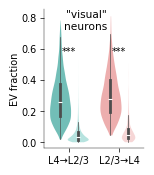

In [92]:
import matplotlib.pyplot as plt

neuron_property='EV'
variable1='Direction'
variable2='Activity Type'

fontsize=7
fig, ax = plt.subplots(figsize=(1.3,1.8))

fig5_violinplot(df_mouse_visual, x=variable1, y=neuron_property, 
                hue=variable2, ax=ax, y_label='EV fraction', linewidth=0,gap=-0.2, width=0.7,cut=0)
ax.set_title('"visual"\nneurons', fontsize=fontsize*1.1, x=0.42, y=0.8)
plt.show()

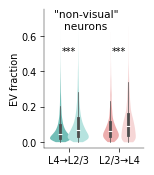

In [93]:
fig, ax = plt.subplots(figsize=(1.3,1.8))

fig5_violinplot(df_mouse_nonvisual, x=variable1, y=neuron_property, 
                hue=variable2, ax=ax, y_label='EV fraction', linewidth=0,gap=-0.2, width=0.7,cut=0)
ax.set_title('"non-visual"\nneurons', fontsize=fontsize*1.1, x=0.42, y=0.8)
plt.show()

In [94]:
df_mouse_corr=pd.merge(df_mouse[df_mouse['Activity Type']=='stimulus'],df_mouse[df_mouse['Activity Type']=='gray screen'], on=['Mouse', 'Mouse Name', 'Area',
       'Direction', 'SNR', 'Split-half r','control_shuffle'])
df_mouse_corr_visual =  df_mouse_corr[(df_mouse_corr['SNR']>2)&(df_mouse_corr['Split-half r']>0.8)&(df_mouse_corr['control_shuffle']==False)] 
df_mouse_corr_nonvisual =  df_mouse_corr[(df_mouse_corr['SNR']<2)&(df_mouse_corr['Split-half r']<0.8)&(df_mouse_corr['control_shuffle']==False)]

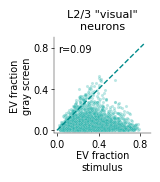

In [95]:
figsize=(1.25,1.25)
fig, ax = plt.subplots(figsize=figsize)
area="L2/3"
plot_corrs_sns(df_mouse_corr_visual, x='EV_x', y='EV_y', area=area,
               ax=ax, xy=(0.01,0.75), color='lightseagreen', alpha=0.3, s=5)
ax.set_title(f'{area} "visual"\nneurons', fontsize=8)
plt.show()

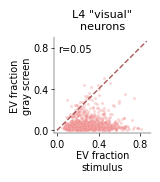

In [96]:
figsize=(1.25,1.25)
fig, ax = plt.subplots(figsize=figsize)
area="L4"
plot_corrs_sns(df_mouse_corr_visual, x='EV_x', y='EV_y', area=area,
               ax=ax, xy=(0.01,0.75), color='lightseagreen', alpha=0.3, s=5)
ax.set_title(f'{area} "visual"\nneurons', fontsize=8)
plt.show()

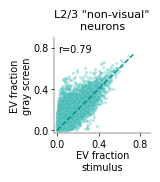

In [97]:
fig, ax = plt.subplots(figsize=figsize)
area="L2/3"
plot_corrs_sns(df_mouse_corr_nonvisual, x='EV_x', y='EV_y', area=area,
               ax=ax, xy=(0.01,0.75), color='lightseagreen', alpha=0.3, s=5)
ax.set_title(f'{area} "non-visual"\nneurons', fontsize=8)
plt.show()

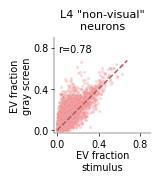

In [98]:
fig, ax = plt.subplots(figsize=figsize)
area="L4"
plot_corrs_sns(df_mouse_corr_nonvisual, x='EV_x', y='EV_y', area=area,
               ax=ax, xy=(0.01,0.75), color='lightseagreen', alpha=0.3, s=5)
ax.set_title(f'{area} "non-visual"\nneurons', fontsize=8)
plt.show()

### supplemental 

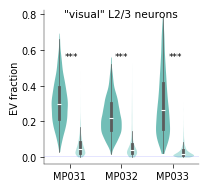

In [238]:
area='L2/3'
x='Mouse Name'
y='EV'
hue='Activity Type'
y_label='EV fraction'
fontsize=7


fig, ax = plt.subplots(figsize=(2,2))
fig5_supp_violinplot(df_mouse_visual,area, x, y, hue, ax, y_label, linewidth=0,cut=0,
                    fontsize=fontsize,plot_control_ev=True, show_legend=False,leg_loc=(1,0.3))
ax.set_title(f'"visual" {area} neurons', fontsize=fontsize*1.1, x=0.5, y=0.9)
plt.show()

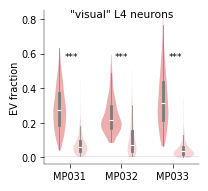

In [239]:
area='L4'

fig, ax = plt.subplots(figsize=(2,2))
fig5_supp_violinplot(df_mouse_visual,area, x, y, hue, ax, y_label, linewidth=0,cut=0,
                    fontsize=fontsize,plot_control_ev=True, show_legend=False,leg_loc=(1,0.3))
ax.set_title(f'"visual" {area} neurons', fontsize=fontsize*1.1, x=0.5, y=0.9)
plt.show()

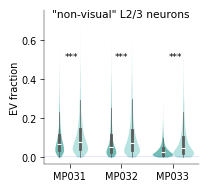

In [240]:
area='L2/3'

fig, ax = plt.subplots(figsize=(2,2))
fig5_supp_violinplot(df_mouse_nonvisual,area, x, y, hue, ax, y_label, linewidth=0,cut=0,
                    fontsize=fontsize,plot_control_ev=True, show_legend=False,leg_loc=(1,0.3))
ax.set_title(f'"non-visual" {area} neurons', fontsize=fontsize*1.1, x=0.5, y=0.9)
plt.show()

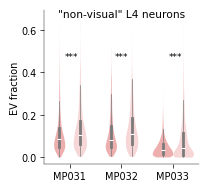

In [241]:
area='L4'

fig, ax = plt.subplots(figsize=(2,2))
fig5_supp_violinplot(df_mouse_nonvisual,area, x, y, hue, ax, y_label, linewidth=0,cut=0,
                    fontsize=fontsize,plot_control_ev=True, show_legend=False,leg_loc=(1,0.3))
ax.set_title(f'"non-visual" {area} neurons', fontsize=fontsize*1.1, x=0.5, y=0.9)
plt.show()

## Monkey stimulus vs. gray screen vs. lights off comparisons

In [ ]:
from neuron_properties_functions import create_empty_monkey_stats_dict, get_SNR_monkey_all_dates, get_split_half_r_monkey_all_dates, get_max_corr_vals_monkey_all_dates, get_evar_monkey_all_dates

monkey_stats= create_empty_monkey_stats_dict()
get_SNR_monkey_all_dates(monkey_stats)
get_split_half_r_monkey_all_dates(monkey_stats)
get_max_corr_vals_monkey_all_dates(monkey_stats)
get_evar_monkey_all_dates(monkey_stats)


In [11]:
import time

start_time = time.time()
from macaque_data_functions import get_resps, get_get_condition_type
dates = ['090817', '100817', '250717']
areas=['V1','V4']
w_size=25
condition_type1 = 'SNR'
condition_type2 = 'SNR_spont'
SNR_lengths = []
SNR_spont_lengths = []
min_lengths = {}
for d, date in enumerate(dates):
    # print(area)
    resp_V4, resp_V1 =get_resps(condition_type=get_get_condition_type(condition_type1), date=date, w_size=w_size)
    SNR_lengths.append(resp_V4.shape[0])
    resp_V4, resp_V1 =get_resps(condition_type=get_get_condition_type(condition_type2), date=date, w_size=w_size)
    SNR_spont_lengths.append(resp_V4.shape[0])
    min_lengths[date]=min(SNR_lengths[-1],SNR_spont_lengths[-1])
print('SNR', SNR_lengths)
print('SNR_spont', SNR_spont_lengths)
print('min lengths',min_lengths)

end_time = time.time()
elapsed_time = (end_time - start_time)/60

print(f'Took {elapsed_time:.4f} minutes to complete')  

SNR [1120, 1216, 1072]
SNR_spont [840, 912, 804]
min lengths {'090817': 840, '100817': 912, '250717': 804}
Took 0.1821 minutes to complete


In [17]:
import time
start_time = time.time()
initial_seed = 17
rng = np.random.default_rng(initial_seed)
# Generate 10 random seed values
num_seeds = 10
seeds = rng.integers(low=0, high=np.iinfo(np.int32).max, size=num_seeds)

from joblib import Parallel, delayed
dates = ['090817', '100817', '250717']
condition_types = ['SNR','RS', 'RS_open', 'RS_closed']
area='V4'
area2='V1'
alphas = [1e2,5e2,1e3,5e3,1e4,5e4,1e5,5e5,1e6]
seed=17

for condition_type in condition_types:
    for date in monkey_stats[condition_type]:
        resp_V4, resp_V1, =get_resps(condition_type=get_get_condition_type(condition_type), date=date, w_size=w_size)
        results = Parallel(n_jobs=-1)(delayed(process_evar_subsample_seeds)(resp_V1, resp_V4, date, min_lengths, seed, alphas, condition_type) for seed in seeds)
        all_v4_evars = np.array([a for a,_ in results])
        all_v1_evars = np.array([a for _,a in results])
        monkey_stats[condition_type][date][area]['spont_comparison_evars']=all_v4_evars
        monkey_stats[condition_type][date][area2]['spont_comparison_evars']=all_v1_evars
    print(f'{condition_type} done')

end_time = time.time()
elapsed_time = (end_time - start_time)/60
print(f'Yay! work is completed. Took {elapsed_time:.4f} minutes to complete')   

SNR done
RS done
RS_open done
RS_closed done
Yay! work is completed. Took 7.0330 minutes to complete


In [18]:
### shuffle control
start_time = time.time()
for condition_type in condition_types:
    for date in monkey_stats[condition_type]:
        resp_V4, resp_V1, =get_resps(condition_type=get_get_condition_type(condition_type), date=date, w_size=w_size)
        results = Parallel(n_jobs=-1)(delayed(process_evar_subsample_seeds)(resp_V1, resp_V4, date, min_lengths, seed, alphas, condition_type) for seed in seeds)
        all_v4_evars = np.array([a for a,_ in results])
        all_v1_evars = np.array([a for _,a in results])
        monkey_stats[condition_type][date][area]['spont_comparison_evars_null']=all_v4_evars
        monkey_stats[condition_type][date][area2]['spont_comparison_evars_null']=all_v1_evars
    print(f'{condition_type} done')
end_time = time.time()
elapsed_time = (end_time - start_time)/60
print(f'Yay! work is completed. Took {elapsed_time:.4f} minutes to complete') 

SNR done
RS done
RS_open done
RS_closed done
Yay! work is completed. Took 6.8871 minutes to complete


### plotting

In [136]:
df_monkey = make_monkey_df(monkey_stats, dataset_types=['SNR','SNR_spont','RS','RS_open','RS_closed'], spont_comparisons=True)
df_monkey_visual =  df_monkey[(df_monkey['SNR']>2)&(df_monkey['Split-half r']>0.8)] 


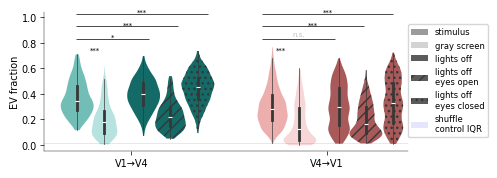

In [194]:
import matplotlib.pyplot as plt

neuron_property='EV'
variable1='Direction'
variable2='Activity Type'

fontsize=7
figsize=(4.7,1.8)
fig, ax = plt.subplots(figsize=figsize)
fig5_violinplot(df_monkey_visual, x=variable1, y=neuron_property, 
                hue=variable2, ax=ax, y_label='EV fraction', palette=['#9b9b9b','lightgray','#5b5b5b','#5b5b5b','#5b5b5b'],
                linewidth=0,gap=-0.2, width=0.7,cut=0, animal='monkey', show_legend=True, leg_loc=(1,0.1))
plt.show()

In [203]:
df_monkey_corr_ = df_monkey_visual[df_monkey_visual['Activity Type']=='stimulus']
for act_type in df_monkey['Activity Type'].unique()[1:]:
    df_copy = df_monkey_visual[df_monkey_visual['Activity Type']==act_type].copy()
    df_copy.rename(columns={'EV': f'EV {act_type}', 'Activity Type':f'Activity Type {act_type}', 'max corr. val': f'max corr. val{act_type}','Dataset Type':f'Dataset Type {act_type}'}, inplace=True)
    df_monkey_corr_= pd.merge(df_monkey_corr_ ,df_copy, on=['Date', 'Area',
    'Direction', 'SNR', 'Split-half r','control_shuffle'])
df_monkey_corr = df_monkey_corr_[df_monkey_corr_['control_shuffle']==False]

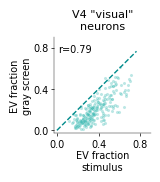

In [209]:
figsize=(1.25,1.25)
fig, ax = plt.subplots(figsize=figsize)
area="V4"
plot_corrs_sns(df_monkey_corr, x='EV', y='EV gray screen', area=area,
               ax=ax, xy=(0.01,0.75), alpha=0.3, s=5)
ax.set_title(f'{area} "visual"\nneurons', fontsize=8)
plt.show()



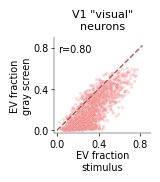

In [210]:
figsize=(1.25,1.25)
fig, ax = plt.subplots(figsize=figsize)
area="V1"
plot_corrs_sns(df_monkey_corr, x='EV', y='EV gray screen', area=area,
            ax=ax, xy=(0.01,0.75), alpha=0.3, s=5)
ax.set_title(f'{area} "visual"\nneurons', fontsize=8)
plt.show()

### supplemental

In [273]:

data = []
for condition_type in df_monkey_visual['Activity Type'].unique():
    for date in df_monkey_visual.Date.unique():
        for pred_type in df_monkey_visual.Direction.unique():
            data.append({
                'Activity Type':condition_type,
                'Date': date,
                'Direction': pred_type,
                'EV_corr_w_SNR':df_monkey_visual[(df_monkey_visual['Activity Type'] =='stimulus')&(df_monkey_visual.Direction==pred_type)&(df_monkey_visual.Date==date)&(df_monkey_visual.control_shuffle==False)].reset_index()['EV'].corr(df_monkey_visual[(df_monkey_visual['Activity Type'] ==condition_type)&(df_monkey_visual.Direction==pred_type)&(df_monkey_visual.Date==date)&(df_monkey_visual.control_shuffle==False)].reset_index()['EV'])
            })
df_SNR_EV_corr = pd.DataFrame(data) 

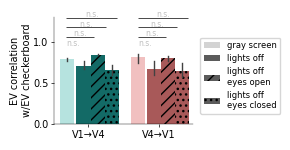

In [274]:
from matplotlib import patches

directions = ['V1→V4', 'V4→V1']
fig, ax=plt.subplots(figsize=(1.8,1.4))
sns.barplot(df_SNR_EV_corr[df_SNR_EV_corr['Activity Type'].isin(df_SNR_EV_corr['Activity Type'].unique()[1:])], 
            x=variable1, order = directions, y='EV_corr_w_SNR', palette=['lightgray','#5b5b5b','#5b5b5b','#5b5b5b'],
            hue='Activity Type',
            width=0.8, ax=ax,
            err_kws={'linewidth': 1}
            )

custom_colors = ['#B6E3DF','#F1C0C0',
                '#136a66','#a85959',
                '#136a66','#a85959',
                '#136a66','#a85959',]
bars  = [s for s in ax.get_children() if isinstance(s, patches.Rectangle)]
lines = ax.get_lines()
offset_val=0.03
hatch_size=3
for b, (bar, line, color)in enumerate(zip(bars, lines, custom_colors)):
    bar.set_facecolor(color)
    if b==4 or b==5:
        bar.set_hatch('/'*hatch_size)
    if b==6 or b==7:
        bar.set_hatch('.'*hatch_size)
    if b>1:
        line.set_xdata(line.get_xdata()+offset_val)
        bar.set_x(bar.get_x()+offset_val)

hatches = [None,None,'/','.',None]
new_handles = []
for handle, hatch in zip(ax.get_legend_handles_labels()[0], hatches):
    if hatch is not None:
        handle.set_hatch(hatch*hatch_size)
    new_handles.append(handle)
ax.legend(loc=(1.05,0.1), handles = new_handles, fontsize=6)

ax.tick_params(axis='both', labelsize=7,  width=0.5, length=2, pad=2)
ax.set_xticks(ticks=ax.get_xticks(), labels=['V1→V4', 'V4→V1'])
ax.set_ylabel('EV correlation\nw/EV checkerboard', fontsize=7, labelpad=1)
ax.set_xlabel(None)
ax.spines[:].set_linewidth(0.3)
ax.set_ylim(0,1.3)


add_anova_stars_2_sets_5_conditions(df_SNR_EV_corr[df_SNR_EV_corr["Activity Type"].isin(df_SNR_EV_corr['Activity Type'].unique()[1:])],
                                    neuron_property='EV_corr_w_SNR', x=variable1,
                                    x_order=directions,hue='Activity Type',hue_order=df_SNR_EV_corr['Activity Type'].unique()[1:], 
                                    ax=ax, fontsize=5.5)

sns.despine()
plt.show()

In [263]:
import time

start_time = time.time()
from macaque_data_functions import get_resps, get_get_condition_type
dates = ['260617', '280617']
areas=['V1','V4']
w_size=25
get_condition_type = 'RF_spont'
min_lengths = {}
for d, date in enumerate(dates):
    # print(area)
    resp_V4, resp_V1 =get_resps(condition_type=get_condition_type, date=date, w_size=w_size)
    min_lengths[date]=resp_V4.shape[0]
print('min lengths',min_lengths)
end_time = time.time()
elapsed_time = (end_time - start_time)/60
print(f'Took {elapsed_time:.4f} minutes to complete')  

min lengths {'260617': 8592, '280617': 11124}
Took 0.8144 minutes to complete


In [264]:
import time
start_time = time.time()
initial_seed = 17
rng = np.random.default_rng(initial_seed)
# Generate 10 random seed values
num_seeds = 10
seeds = rng.integers(low=0, high=np.iinfo(np.int32).max, size=num_seeds)

from joblib import Parallel, delayed
dates = ['260617', '280617']
condition_types = ['RF_large','RF_thin']
area='V4'
area2='V1'
alphas = [1e2,5e2,1e3,5e3,1e4,5e4,1e5,5e5,1e6]
seed=17

for condition_type in condition_types:
    for date in monkey_stats[condition_type]:
        resp_V4, resp_V1, =get_resps(condition_type=get_get_condition_type(condition_type), date=date, w_size=w_size)
        results = Parallel(n_jobs=-1)(delayed(process_evar_subsample_seeds)(resp_V1, resp_V4, date, min_lengths, seed, alphas, condition_type) for seed in seeds)
        all_v4_evars = np.array([a for a,_ in results])
        all_v1_evars = np.array([a for _,a in results])
        monkey_stats[condition_type][date][area]['spont_comparison_evars']=all_v4_evars
        monkey_stats[condition_type][date][area2]['spont_comparison_evars']=all_v1_evars
    print(f'{condition_type} done')

end_time = time.time()
elapsed_time = (end_time - start_time)/60
print(f'Yay! work is completed. Took {elapsed_time:.4f} minutes to complete')   

RF_large done
RF_thin done
Yay! work is completed. Took 2.4983 minutes to complete


In [265]:
### shuffle control
start_time = time.time()
for condition_type in condition_types:
    for date in monkey_stats[condition_type]:
        resp_V4, resp_V1, =get_resps(condition_type=get_get_condition_type(condition_type), date=date, w_size=w_size)
        results = Parallel(n_jobs=-1)(delayed(process_evar_subsample_seeds)(resp_V1, resp_V4, date, min_lengths, seed, alphas, condition_type) for seed in seeds)
        all_v4_evars = np.array([a for a,_ in results])
        all_v1_evars = np.array([a for _,a in results])
        monkey_stats[condition_type][date][area]['spont_comparison_evars_null']=all_v4_evars
        monkey_stats[condition_type][date][area2]['spont_comparison_evars_null']=all_v1_evars
    print(f'{condition_type} done')
end_time = time.time()
elapsed_time = (end_time - start_time)/60
print(f'Yay! work is completed. Took {elapsed_time:.4f} minutes to complete') 

RF_large done
RF_thin done
Yay! work is completed. Took 2.4463 minutes to complete


In [266]:
df_monkey_RF = make_monkey_df(monkey_stats, dataset_types=['RF_large','RF_large_spont','RF_thin','RF_thin_spont'], spont_comparisons=True)
df_monkey_RF_visual =  df_monkey[(df_monkey['SNR']>2)&(df_monkey['Split-half r']>0.8)]

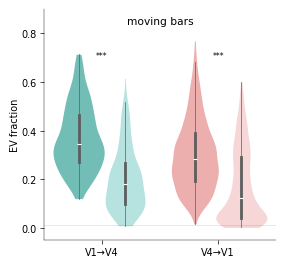

In [272]:
figsize=(3,3)
fontsize=7
label_order=['V1→V4', 'V4→V1']
hue_order=['stimulus', 'gray screen']
x='Direction'
y='EV'
hue='Activity Type'
fig, ax = plt.subplots(figsize=figsize)

sns.violinplot(x=x, y=y, hue=hue, 
                data=df_monkey_RF_visual[df_monkey_RF_visual['control_shuffle']==False],ax=ax,order=label_order, hue_order=hue_order,
                inner='box',linewidth=0,saturation=1, gap=-.1, width=0.8,
                inner_kws={'box_width':2, 'whis_width':0.5,
                            'marker':'_', 'markersize':3,
                            'markeredgewidth':0.8,
                            },palette=['#9b9b9b','lightgray'],cut=0,
                            )

ax.legend_.remove()
custom_colors = ['#72BEB7','#B6E3DF',
                '#EDAEAE', '#f6d6d6',]
violins  = [s for s in ax.get_children() if isinstance(s, collections.PolyCollection)]
for violin, color in zip(violins, custom_colors):
    violin.set_facecolor(color)

ax.tick_params(axis='both', labelsize=fontsize, width=0.5, length=3, pad=2)
ax.set_ylabel('EV fraction', fontsize=fontsize, labelpad=1)
ax.set_xlabel(None)
ax.set_ylim(bottom=-0.05,top=0.9)
sns.despine()
add_stars_2_sets(df_monkey_RF_visual[df_monkey_RF_visual['control_shuffle']==False], neuron_property, variable1, 
                    x_order=directions,hue=variable2, 
                    ax=ax, fontsize=5.5, mouse_or_date='Date', 
                    height1=0.8, height2=0.8,
                    perm_type='paired')
ax.spines[:].set_linewidth(0.3)
ax.set_title('moving bars', fontsize=fontsize*1.1, x=0.5, y=0.9)
data = df_monkey_RF_visual[df_monkey_RF_visual['control_shuffle']==True][neuron_property]
per_25 = np.percentile(data.dropna().values, 25)
per_75 = np.percentile(data.dropna().values, 75)
ax.axhspan(per_25, per_75, alpha=0.1, color='blue', label='shuffle\ncontrol IQR',
        linewidth=0,
           )
plt.show()

